In [1]:
import os 
import pandas as pd 
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def parse_experiment_name(filename): 
    sample, model, dataset, num_hidden, outputscale = filename.split('-')
    num_hidden = num_hidden.split("=")[1]
    outputscale = outputscale.split("=")[1]
    return sample, model, dataset, num_hidden, outputscale

In [3]:
def combine_experiments(root_dir):
    dfs = []
    for experiment_name in os.listdir(root_dir): 
        # exclude non-pathwise-vs-naive experiments 
        if not experiment_name.startswith('naive') and not experiment_name.startswith('pathwise'): 
            continue 

        sample, model, dataset, num_hidden, outputscale = parse_experiment_name(experiment_name)
        experiment_path = os.path.join(root_dir, experiment_name)
        for version in os.listdir(experiment_path):
            experiment_df = pd.DataFrame.from_dict(dict(
                sample=[sample], model=[model], dataset=[dataset], num_hidden=[num_hidden], outputscale=[outputscale], run=[version.split('_')[1]]
            ))
            file_path = os.path.join(experiment_path, version, 'metrics.csv')
            if os.path.exists(file_path):
                metrics_df = pd.read_csv(file_path)
                df = pd.concat([experiment_df, metrics_df], axis=1)
                dfs.append(df)
    data = pd.concat(dfs)
    data = data.fillna(method='ffill')
    data = data[data['num_hidden'].astype(int).isin({1, 2}) & (data['dataset'] == 'singular')]
    data['sample'] = data['sample'].map({'naive': "Marginal", "pathwise": "Joint"})
    return data

In [4]:
root_dir = '../logs/csv/val/'
data = combine_experiments(root_dir)

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.dpi'] = 500
sns.set_theme(style='whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

In [6]:
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set(style="whitegrid", 
        rc={
           "text.usetex": True,
           "font.family": "serif",
           "font.serif": ["Times New Roman", "Computer Modern Roman"], 
        })

In [33]:
mpl.rcParams['figure.figsize'] = [7, 4]  # width, height in inches
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.titlesize'] = 20


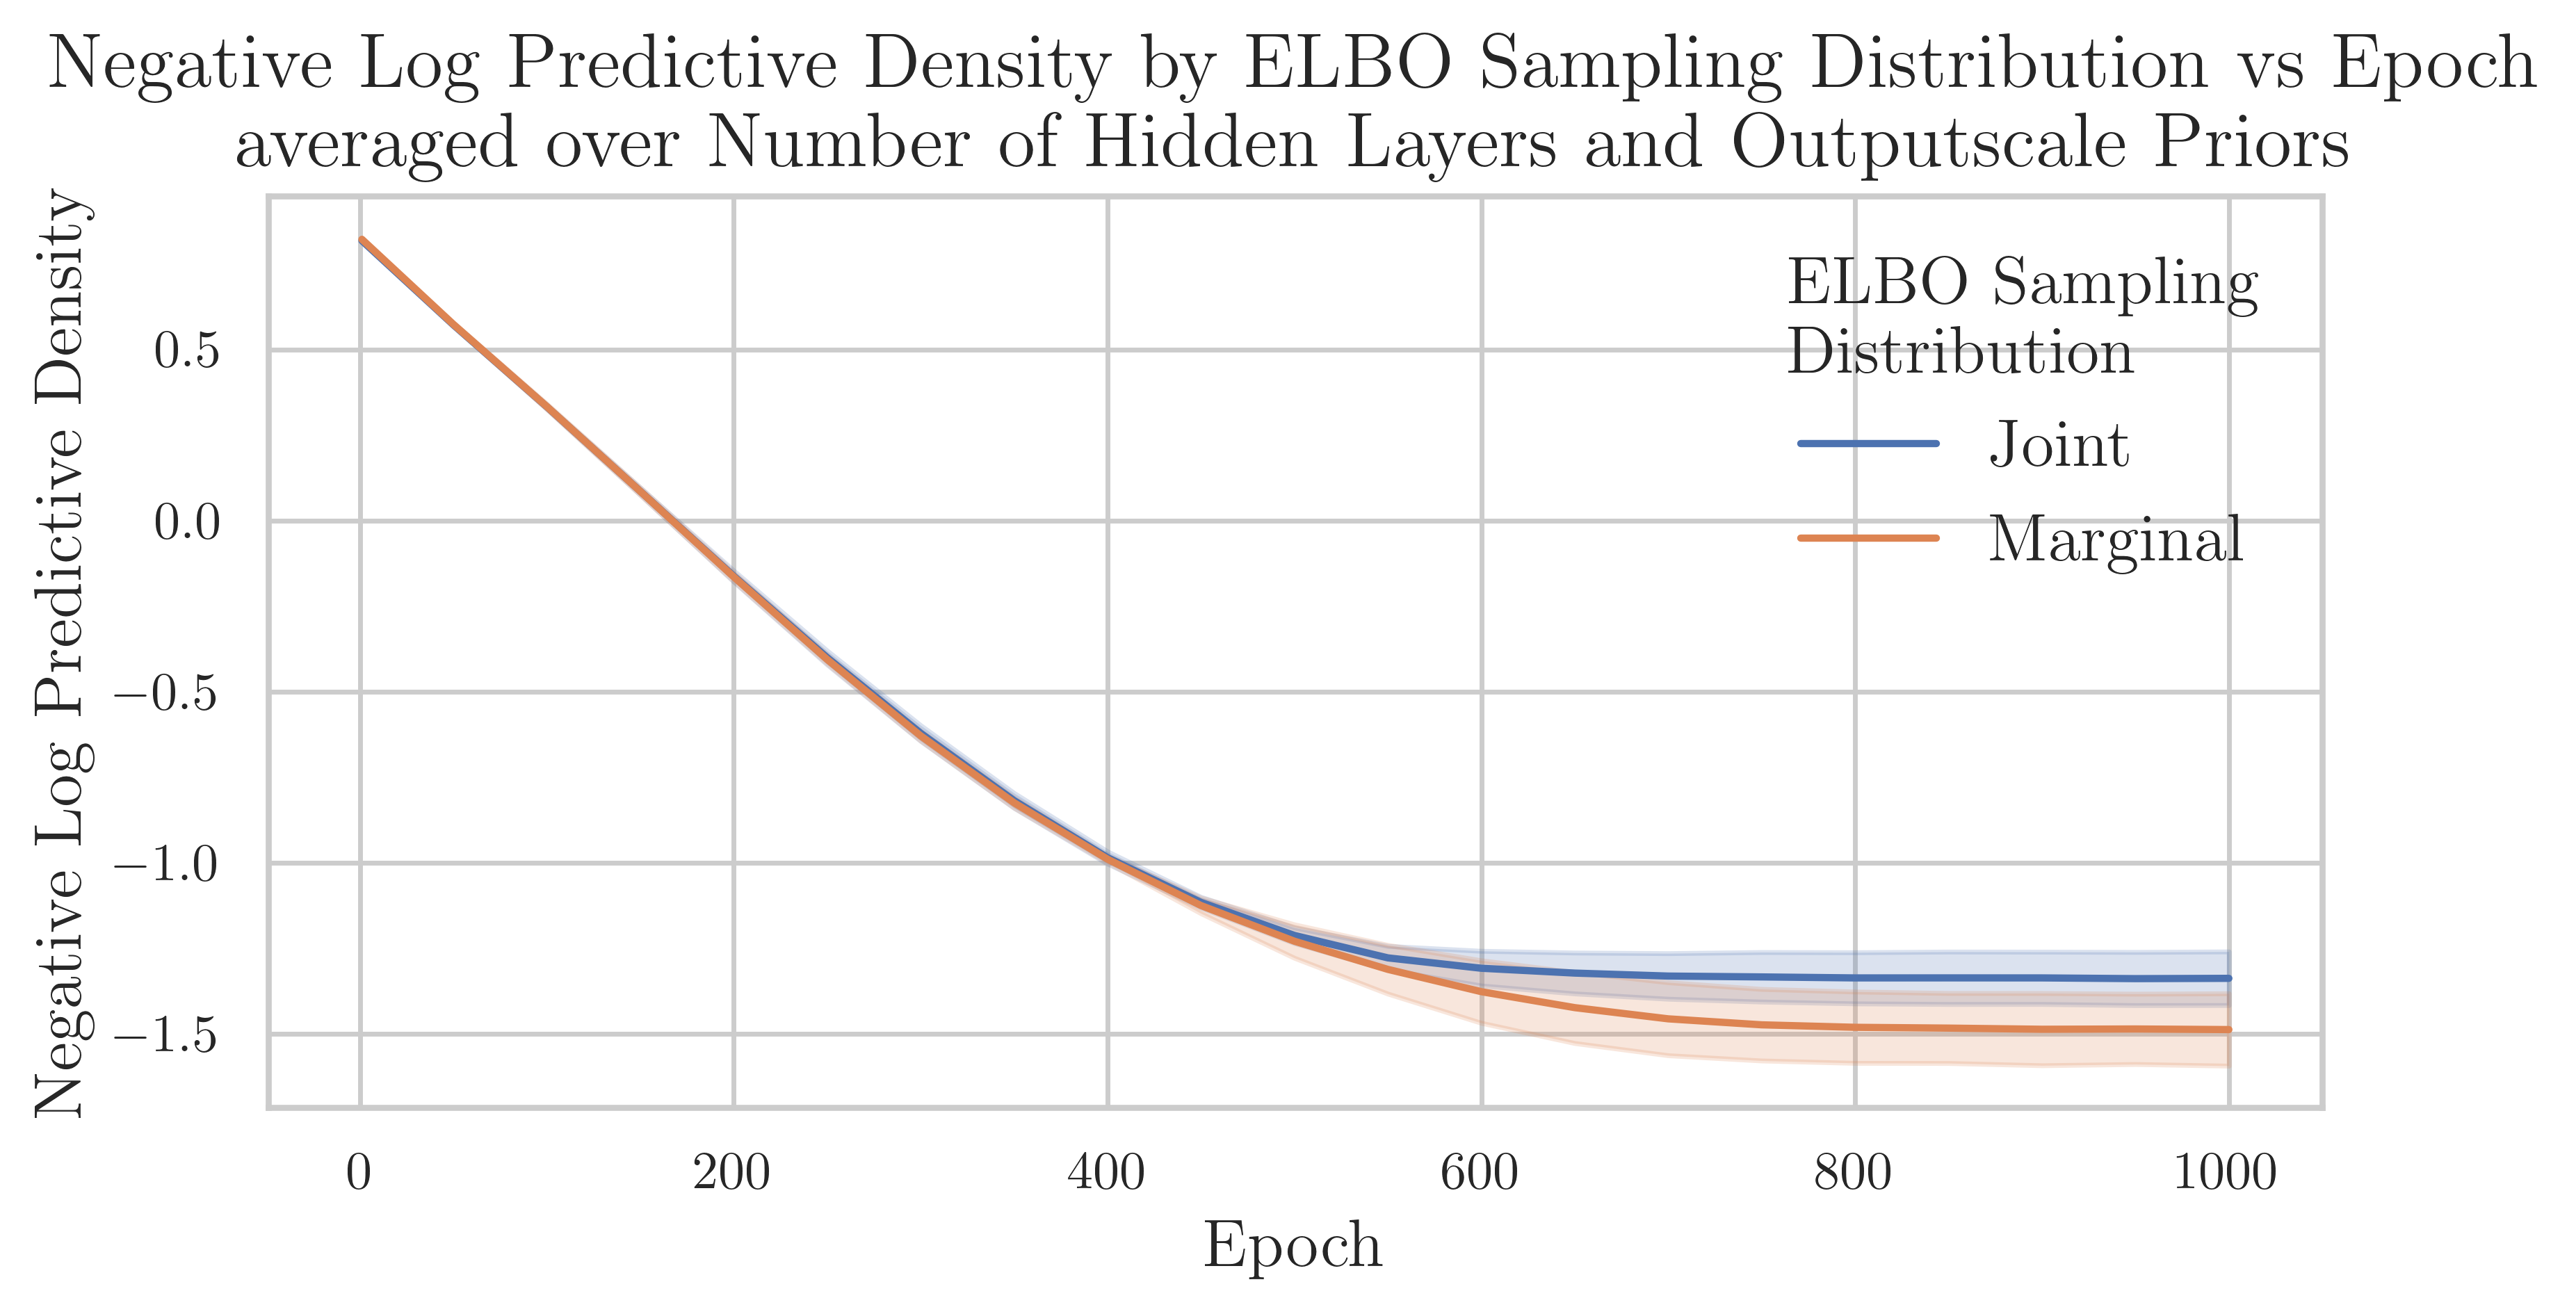

In [41]:
sns.lineplot(data=data, 
             x='step', 
             y='negative_log_predictive_density', 
             hue='sample',
             errorbar='sd')

plt.title('Negative Log Predictive Density by ELBO Sampling Distribution vs Epoch\naveraged over Number of Hidden Layers and Outputscale Priors', size=16)
plt.xlabel('Epoch', size=14)
plt.ylabel('Negative Log Predictive Density', size=14)
plt.legend(title='ELBO Sampling\nDistribution', fontsize=14, title_fontsize=14)
plt.grid(True)
plt.savefig('../report_plots/nlpd_by_elbo_sampling_dist_vs_epoch.png')
plt.tight_layout()
plt.show()

<Figure size 3200x2400 with 0 Axes>

# Test metrics 

In [84]:
root_dir = '../logs/csv/test/'
data = combine_experiments(root_dir).sort_values(by='outputscale')
data['num_hidden'] = data['num_hidden'].astype(int)

In [97]:
fig = make_subplots(
    rows=2, cols=1, 
    x_title="Standard Deviation Prior Mean and Standard Deviation", 
    y_title="Negative Log Predictive Density", 
    row_titles=["2 Hidden Layers", "1 Hidden Layer"], 
    shared_xaxes=True,
    vertical_spacing=0.1,
)

def get_trace(num_hidden, sample, side, color, showlegend=True, pointpos=None): 
    df = data[(data['num_hidden'] == num_hidden) & (data['sample'] == sample)]
    return go.Violin(
        x=df['outputscale'], 
        y=df['test-negative_log_predictive_density'], 
        legendgroup=sample,
        scalegroup=sample, 
        name=sample, 
        side=side, 
        line_color=color,
        showlegend=showlegend,
        pointpos=pointpos, 
    )

hidden1 = data['num_hidden'] == 1
sample_joint = data['sample'] == 'Joint'

fig.add_trace(get_trace(1, 'Joint', 'negative', 'orange', True, -0.7), row=1, col=1)
fig.add_trace(get_trace(1, 'Marginal', 'positive', 'blue', True, 0.7), row=1, col=1)
fig.add_trace(get_trace(2, 'Joint', 'negative', 'orange', False, -0.7), row=2, col=1)
fig.add_trace(get_trace(2, 'Marginal', 'positive', 'blue', False, 0.7), row=2, col=1)

fig.update_layout(
    xaxis_title="", 
    yaxis_title="", 
    title="Negative Log Predictive Density Distribution by ELBO Sampling Distribution<br>vs Number of Hidden Layers and Hidden Layer Standard Deviation Prior ", 
    legend=dict(
        title="ELBO Sampling<br>Distribution", 
        x=1.05, 
        y=0.55,
        yanchor='middle',
    ),
    width=700, 
    height=450, 
    font_family="Serif",
    title_font_size=20,
    font_size=14,
)
fig.update_traces(meanline_visible=True, points='all')
fig.update_layout(violingap=0, violinmode='overlay')
fig.update_yaxes(range=[-1.8, -1.2], row=1, col=1) 
fig.update_yaxes(range=[-1.8, -1.2], row=2, col=1)
fig.show()
fig.write_image('../report_plots/nlpd_vs_elbo_sampling_distribution.jpg', scale=6, width=700, height=450)